In [2]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
x = np.arange(15)
print(x)
print(np.roll(x, 1))
#array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7])

print(np.roll(x, -1))
#array([2, 3, 4, 5, 6, 7, 8, 9, 0, 1])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[14  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14  0]


In [ ]:
# test with csv
mat1 = pd.read_csv('datasets-b3/APER3.csv')
mat2 = pd.read_csv('datasets-b3/BEES3.csv')

In [ ]:
var = []
var.append(('BEES3', 'BEES3', 0.555))
var.append(('BEES3', 'BEES3', 0.555))
var.append(('BEES3', 'BEES3', 0.555))
var.append(('BEES3', 'BEES3', 0.555))
var

In [ ]:
type(var)
type(var[0])

In [ ]:
var2 = {}

In [ ]:
type(var2)

In [ ]:
data = pd.read_csv('datasets/data.csv', index_col=0)
data

In [ ]:
rows = []
rows.append(["ABC","CDE",0.56663])
rows.append(["ABC","CDE",0.56663])

df = pd.DataFrame(rows, columns=['A', 'B', 'C'])
df

In [ ]:
len(rows)

In [ ]:
data = pd.read_csv('datasets/data.csv', index_col=0)

In [ ]:
y = data['AALR3']
x = sm.add_constant(data['ALSO3'])
result = sm.OLS(y, x).fit()
print(result.params)
print(result.t_test([1, 0]))
print(result.summary())

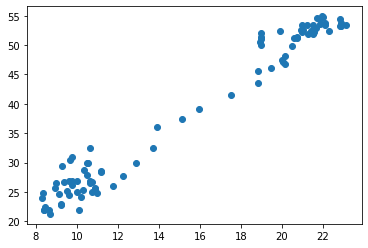

In [63]:
#plt.figure(figsize=(15,6))
plt.scatter(data['AALR3'], data['ALSO3'])

In [77]:
test = pd.DataFrame(data['ALSO3'])
test.columns=['Fechamento']

In [80]:
index = 1
current = test['Fechamento'].iloc[index]
last = test['Fechamento'].iloc[(index+1)]

current, last, (current/last)-1

(51.42, 51.07, 0.006853338554924537)

In [89]:
test['Var'] = 0
lenght = len(test)
for index in range(lenght):
    if(index == lenght-1):
        break

    current = test['Fechamento'].iloc[index]
    last = test['Fechamento'].iloc[(index+1)]
    var = (current/last)-1
    test['Var'].iloc[index+1] = var

test

,Fechamento,Var
0,50.01,0.000000
1,51.42,-0.027421
2,51.07,0.006853
3,50.47,0.011888
4,52.00,-0.029423
...,...,...
87,21.95,0.041913
88,21.90,0.002283
89,22.01,-0.004998
90,22.38,-0.016533


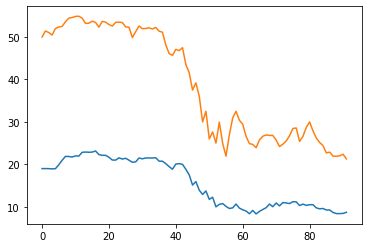

In [92]:
plt.plot(data['AALR3'])
plt.plot(data['ALSO3'])

In [8]:
numbers = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
print(numbers[:5])
print(numbers[15:])
print(numbers[5:10])

[1, 2, 3, 4, 5]
[16, 17, 18, 19, 20]
[6, 7, 8, 9, 10]
